# Рекомендация тарифов

**Описание проекта:**

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Компания «Мегалайн» хочет построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

**Цель работы:**

В рамках данной проектной работы необходимо построить модель рекомендации тарифов, доля правильных ответов должна составлять не менее 75%.

## Анализ данных

### Импортирование библиотек

В данном разделе будет проведен импорт всех необходимых библиотек.

In [1]:
#импортируем необходимые для работы библиотеки
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

### Изучение полученных данных

Откроем полученные данные и проведем общий анализ.

In [2]:
#откроем файл с данными
df = pd.read_csv('/datasets/users_behavior.csv')

#выведем на экран 10 строк из файла
df.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [3]:
#получим информацию о загруженном датасете
print (df.info(),'\n')

#рассмотрим сколько пользователей пользуются тарифом "Смарт" и "Ультра"
print('Количетво пользователи тарифа "Смарт(0)" и "Ультра(1)":')
print(df['is_ultra'].value_counts())

#сформируем детальную информацию о каждом столбце датасета
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None 

Количетво пользователи тарифа "Смарт(0)" и "Ультра(1)":
0    2229
1     985
Name: is_ultra, dtype: int64


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [4]:
2229/3214

0.693528313627878

In [5]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


### Вывод по блоку "Анализ данных":

Был предоставлен датасет с расшифровкой трафика пользователей мобильного оператора "Мегалайн". Каждая строка - информация об одном пользователе за месяц. 

Датасет имеет следующие колонки:
- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

После загрузке данных было установлено, что в датасете 3214 записей. Пустые значения отсутствуют, тип данных для каждой колонки соответствует находящемся в данных колонках данных, аномальные значения отсутствуют. Данные являются предобработанными.

Для общего понимания было обнаружено, что тарифом "Смарт" пользуются **2229** (**69%**) пользователей, а тарифом "Ултра" - **985** (**31%**) пользователей.

## Подготовка выборок и обучение модели

В данном блоке будет проведена следующая работа:
- подготовка выборок для обучения и тестирования модели.
- обучение модели разными алгоритмами и определение наиболее качественной модели рекомендаций.

### Разделение данных на выборки 

Для проведения корректного тестирования модели необходимо подготовить 3 выборки:
- обучающую;
- валидационную;
- тестовую.

Выборки будут получены на основе имеющихся данных и разделены в пропорции 3:1:1, таким образом `обучающая` выборка будет составлять **60%**, `валидационная` - **20%** и `тестовая` - **20%**.

In [6]:
#для начала разделим наш датасет на данные - признаки (features) и целевые значения (target)
features= df.drop(['is_ultra'], axis =1)
target = df['is_ultra']

#для контроля за количеством данных выборках выведем размеры features и target методом '.shape()'
print('Размер "features"/"target" до деления: ',features.shape,' / ', target.shape)

#для составления выборок используем функцию `train_test_split` дважды:
#популяцию разделим на две выборки - обучающую(train) и тест-валидационную(test_valid) 
features_train,features_test_valid, target_train , target_test_valid = (
train_test_split (features, target, test_size = 0.4, random_state = 12345, stratify = target))

#далее разделим тест-валидационную на валидационную выборку и выборку для тестирования
features_valid,features_test,target_valid,target_test = (
train_test_split(features_test_valid, target_test_valid, test_size = 0.5, random_state = 12345, stratify = target_test_valid))

#убедимся что при делении не потеряли данные
print('features и target для обучающей выборки',features_train.shape,' / ', target_train.shape)
print('features и target для валидационной выборки',features_valid.shape,' / ', target_valid.shape)
print('features и target, для тестовой выборки',features_valid.shape,' / ', target_valid.shape)

Размер "features"/"target" до деления:  (3214, 4)  /  (3214,)
features и target для обучающей выборки (1928, 4)  /  (1928,)
features и target для валидационной выборки (643, 4)  /  (643,)
features и target, для тестовой выборки (643, 4)  /  (643,)


### Обучение модели на алгоритме - решающее дерево (DecisionTreeClassifier)

Проведем обучение модели алгоритмом - решающее дерево. В данном алгоритме важным параметром является глубина дерева(`max_depth`), для определения оптимального значения данного гиперпараметра построим функцию, которая будет перебирать различные значения данного параметра и определит значения с наиболее высоким качеством модели.

100%|██████████| 24/24 [00:00<00:00, 79.05it/s]


Качество модели составляет: 0.80248833592535 Глубина дерева: 8


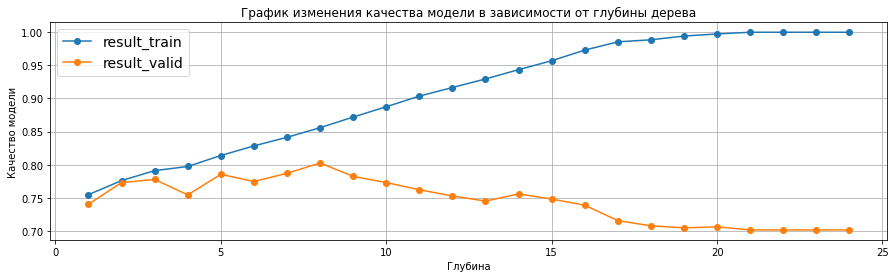

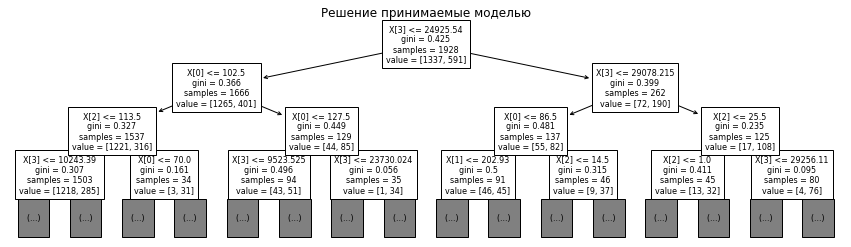

In [7]:
#напишем функцию для перебора максимального значения глубины для алгоритма решающего дерева

best_tree_depth = 0
best_tree_result = 0
depth_plt_result = pd.DataFrame({'depth':[], 'result_train':[], 'result_valid':[]})

for depth in tqdm(range(1,25)):
    model_tree = DecisionTreeClassifier(random_state = 12345, max_depth = depth)
    model_tree.fit(features_train, target_train)
    
    predictions_train_tree = model_tree.predict(features_train) 
    predictions_valid_tree = model_tree.predict(features_valid)
    
    result_valid_tree = accuracy_score(target_valid, predictions_valid_tree)
    result_train_tree = accuracy_score(target_train, predictions_train_tree)
    
    if best_tree_result < result_valid_tree:
            best_tree_result = result_valid_tree
            best_tree_depth = depth
    
    depth_plt_result = depth_plt_result.append ({'depth': depth, 
                                                 'result_train': result_train_tree, 
                                                 'result_valid': result_valid_tree}, ignore_index = True)
    
print('Качество модели составляет:', best_tree_result,'Глубина дерева:',best_tree_depth)

plt.rcParams ['figure.figsize'] = [15, 4]
fig, ax = plt.subplots()
ax.plot (depth_plt_result['depth'], depth_plt_result['result_train'], 'o-', label = 'result_train')
ax.plot (depth_plt_result['depth'], depth_plt_result['result_valid'], 'o-', label = 'result_valid')
plt.title ('График изменения качества модели в зависимости от глубины дерева')
plt.xlabel ('Глубина')
plt.ylabel ('Качество модели')
plt.legend(fontsize=14)
plt.grid()
plt.show()

tree.plot_tree(model_tree, max_depth = 3, fontsize = 8)
plt.title('Решение принимаемые моделью')
plt.show()

### Обучение модели на алгоритме - случайный лес (RandomForestClassifier)

Проведем обучение модели алгоритмом - случайный лес. В данном алгоритме важным параметром является глубина дерева(`max_depth`) и количество деревьев (`n_estimators`), для определения оптимального значения данных гиперпараметров построим функцию, которая будет перебирать различные значения данных параметров и определит значения с наиболее высоким качеством модели.

In [8]:
#напишем функцию для перебора максимального значения глубины и количества деревьев для алгоритма случайного леса.

best_forest_result = 0
best_forest_depth = 0
best_forest_n_estimators = 0

for est in tqdm(range (1,50)):
    for depth in range (1,10):
        model_forest = RandomForestClassifier (random_state = 12345, n_estimators = est, max_depth = depth)
        model_forest.fit(features_train,target_train)
        predictions_forest = model_forest.predict(features_valid)
        result_forest = accuracy_score (target_valid, predictions_forest)
        if best_forest_result < result_forest:
            best_forest_result = result_forest
            best_forest_n_estimators = est
            best_forest_depth = depth

print('Качество модели составляет:', best_forest_result, 
      'Глубина дерева:',  best_forest_depth,
      'Количество деревьев:', best_forest_n_estimators, '\n')

100%|██████████| 49/49 [00:30<00:00,  1.60it/s]

Качество модели составляет: 0.8227060653188181 Глубина дерева: 9 Количество деревьев: 39 



### Обучение модели на алгоритме - логистическая регрессия (LogisticRegression)

Проведем обучение модели алгоритмом - логистическая регрессия. В данном алгоритме важным параметром является выбор расчета (`solver`), примем данный гиперпараметр равным `'lbfgs'` - самый распространенный вариант.

Также важным гиперпарметром является количество итираций (`max_iter`) для определения оптимального значения данного гиперпараметра построим функцию, которая будет перебирать различные значения данного параметра и определит значения с наиболее высоким качеством модели.

In [9]:
#напишем функцию для перебора максимального значения количества итераций

best_log_result = 0
best_iters = 0

for iters in tqdm(range(100, 10000, 100)):
    model_log = LogisticRegression(random_state = 12345, solver = 'lbfgs', max_iter = iters)
    model_log.fit(features_train, target_train)
    predictions_log = model_log.predict (features_valid)
    result_log = accuracy_score (target_valid, predictions_log)
    if best_log_result < result_log:
        best_log_result = result_log
        best_iters = iters
        
print('Качество модели составляет:', best_log_result, 
      'Количество итераций:', best_iters)        

100%|██████████| 99/99 [00:03<00:00, 26.05it/s]

Качество модели составляет: 0.7387247278382582 Количество итераций: 100


### Выводы по блоку "Подготовка выборок и обучение модели"

В рамках данного блока было подготовлено три выборки:
- обучающая (**60%**);
- валидационная (**20%**);
- тестовая (**20%**).

На основе обучающей выборки были обучены 3 модели с разными алгоритмами, а также была проведена проверка качества моделей и подбор наиболее оптимального значения гиперпарметров каждой из них:

1. Решающее дерево (DecisionTreeClassifier):

Для данного алгоритма лучшее значение составляет **0.7853810264385692** при гиперпараметре `max_depth` равное **3**.

2. Cлучайный лес (RandomForestClassifier):

Для данного алгоритма лучшее значение составляет **0.8087091757387247** при гиперпараметре `max_depth` равное **8** и `n_estimators` равное **40**.

3. Логистическая регрессия (LogisticRegression):

Для данного алгоритма лучшее значение составляет **0.7107309486780715** при гиперпараметре `max_iter` равное **100**

Таким образом для проверки модели на тестовой выборке будет использована модель №2 - случайный лес (RandomForestClassifier), при значении гиперпараметров:
- `max_depth` = 8
- `n_estimators`= 40

## Тестирование модели и проверка на адекватность

В данном блоке будет проведена проверка модели на тестовой выборке, подготовленной в рамках предыдущего блока. Также будет сделана дополнительная проверка модели на адекватность.

### Проведение тестирования модели

В результате изучения различных алгоритмов обучения - наилучший результат был у модели №2 - случайный лес (RandomForestClassifier), при этом значения гиперпараметров были:

- `max_depth` = 8
- `n_estimators`= 40

Проведем проверку тестовой выборки с указанными гиперпараметрами.

In [10]:
#проведем проверку модели на тестовой выборке

model_test = RandomForestClassifier(random_state = 12345, max_depth = 8, n_estimators = 40)
model_test.fit(features_train, target_train)
predictions_test = model_test.predict(features_test)
result_test = accuracy_score (target_test, predictions_test)

print('Точность модели составляет', result_test)

Точность модели составляет 0.8087091757387247


### Улучшения качества модели

Так как на основе предсказаний модели на валидационных признаках мы определили наиболее оптимальные параметры, для улучшения  качества предсказания модели, объединим обучающую и валидационную выборку. На основе новой выборки обучим новую модель и проверим качество предсказания на тестовой выборке.

Дополнительно выведем по новой модели дополнительные метрики:
- precision (точность) -  показывает сколько объектов в предсказании имеют то же значение, что и по факту.
- recall (полнота) - показывает долю объектов которую модель определила верно
- F1 - ближе к единице, если параметры `precision` и `recall` ближе к единице, тоже стремится к единице, в противном случае стремится к нулю.
- confussion matrix - имеет 4 поля и показывает количество значений попавших в эти поля в следующей классификации:
    - Верхнее правое - True Positive
    - Верхнее левое - False Positive
    - Нижнее правое - Fals Negative
    - Нижнее левое - True Negative

In [11]:
# Объединим популяции методом pd.concat()
features_train_valid = pd.concat([features_train, features_valid])
target_train_valid = pd.concat([target_train, target_valid])

model_test_new = RandomForestClassifier(random_state = 12345, max_depth = 8, n_estimators = 40)
model_test_new.fit(features_train_valid, target_train_valid)
predictions_test_new = model_test_new.predict(features_test)
result_test_new = accuracy_score (target_test, predictions_test_new)

print('Точность модели составляет', result_test_new, '\n')

# Выведем дополнительные метрики (precition, recall, f1-score) c помощью classification_report()
report = classification_report(target_test, predictions_test_new, target_names=['1', '0'])

print('Отчет по дополнительным метрикам:','\n', report)

#Построим матрицу ошибок
confusion_matrix = confusion_matrix(target_test, predictions_test_new)
print ('Матрица ошибок:','\n', confusion_matrix)

Точность модели составляет 0.8289269051321928 

Отчет по дополнительным метрикам: 
               precision    recall  f1-score   support

           1       0.83      0.95      0.88       446
           0       0.83      0.56      0.67       197

    accuracy                           0.83       643
   macro avg       0.83      0.75      0.78       643
weighted avg       0.83      0.83      0.82       643

Матрица ошибок: 
 [[423  23]
 [ 87 110]]


### Проверка модели на адекватность

Для проверки модели на адекватность используем алгоритм - DummyClassifier.

Модель ,будет считаться адекватной, если ее значения выше "тривиальной модели". Тривиальной моделью может быть предсказание случайным, или средним (возможно с группировкой по каким-то признакам), или наиболее частым классом. 

В данном случае в качестве параметра `strategy` применим значение - `most_frequent`(самые частые значения)

In [12]:
#обучим модель и проверим ее качество

model_d = DummyClassifier(strategy = 'most_frequent')
model_d.fit(features_train, target_train)
result_d = model_d.score (features_test, target_test)

result_d

0.6936236391912908

### Вывод по блоку "Тестирование модели и проверка на адекватность"

В данном блоке было произведено тестирование выбранной модели. Качество модели, построенной на алгоритме Случайного леса при заданных значениях гиперпараметров, составило ~ **80%**, что соответствует приемлемому уровню качества.

Что касается проверки на адекватность, значение модели обученной по стратегии "Самые частые значения" (параметр `strategy` равен "most_frequent" показал качество модели равное ~ **69%**, что ниже качества основной модели (**80%**), таким образом выбранную модель можно считать адекватной.

## Общий вывод

В ходе выполнения данного проекта была построена модель рекомендации тарифов на основе данных о трафике пользователей мобильного оператора "Мегалайн". Лучшими показателями качества обладает модель построенная на алгоритме "Случайный лес" - качество предсказаний данной модели составляет около **80%**. Детальная информация по проекту представлена ниже: 

В ходе проекта была проведена следующая работа:

**1. Блок "Анализ данных"** 

Был проведен первичный анализ предоставленного датасета.

**2. Блок "Подготовка выборок и обучение модели"** 

На основе полученного датасета были подготовлены 3 выборки:

- обучающая выборка - **60%** от общей популяции - на основе данной выборки производилось обучение моделей;
- валидационная выборка - **20%** от общей популяции - данная выборка служила для проверки качества обученных моделей;
- тестовая выборка - **20%** от общей популяции - выборка для проведения основного тестирования модели, показавшей лучший результат

Далее в данном блоке были обучены 3 модели с применением разных алгоритмов. Для каждой из моделей был проведен подбор значения гиперпараметров, таким образом, чтобы достигалось наиболее высокое качество моделей.

Информация об обученных моделях представлена ниже:

1. Решающее дерево (DecisionTreeClassifier):

Для данного алгоритма лучшее значение составляет **0.7853810264385692** при гиперпараметре `max_depth` равное **3**.

2. Cлучайный лес (RandomForestClassifier):

Для данного алгоритма лучшее значение составляет **0.8087091757387247** при гиперпараметре `max_depth` равное **8** и `n_estimators` равное **40**.

3. Логистическая регрессия (LogisticRegression):

Для данного алгоритма лучшее значение составляет **0.7107309486780715** при гиперпараметре `max_iter` равное **100**

Таким образом был выбран алгоритм №2 - случайный лес с значениями гиперпараметров глубины - равное 8 и количества - равное 40.

**3. Блок "Тестирование модели и проверка на адекватность"**

На основе выбранного алгоритма (*Cлучайный лес (RandomForestClassifier)*) и указанных гиперпараметров была обучена модель.

Проверка модели на тестовой выборке показала, что качество модели составляет **0.8087091757387247** - около **81%**, что соответствует заранее установленной планке качества модели.

Далее, путем увеличения обучающей выборки за счет присоединения к обучающей выборки валидационной, было улучшено качество модели. Качество предсказаний финальной модели составляет **0.8289269051321928** или около **83%**, что выше первоначальной оценки.

Также были сформированы дополнительные метрики:

- precition - значение данной метрики составляет **83**, что говорит о том, что в **83%** случаев определялось корректное значение (предсказание тарифа "ультра" и "стандарт", соответствовало действительности)
- recall - значение данной метрики составляет **95** для тарифа "ультра" и **56** для тарифа стандарт, то есть доля правильных ответов из всех правильных ответов составляет **95%** и **56%** соответственно.
- confusion_matrix показала:
    - Верно определен тариф "Ультра" в 423 случаях;
    - Неверно определен тариф "Ультра" в 23 случаях;
    - Неверно определен тариф "Стандарт" в 87 случаях;
    - Верно определен тариф "Стандарт" в 110 случаях.
    
Таким образом, все метрики имеют достаточно высокое значение показателей, что говорит о хорошем качестве обученной модели.

В дополнение была проведена проверка модели на адекватность.

Тест модели обученной по алгоритму *DummyClassifier*, с указанным параметром `strategy` равным `most_frequent`(самые частые значения), показал более низкое значение качества модели  - **69%**. Таким образом можно утверждать, что модель является адекватной.

**Рекомендации**

Задачей было разработать модель, которая поможет перевести пользователей архивных тарифов на один из двух новых тарифов, однако данную модель можно дополнительно использовать в следующих целях:

Сформировать систему рекомендаций
1. Рекомендации для пользователей тарифа "Стандарт", в случае если модель рекомендуют тариф "Ультра".
    
2. Рекомендации для новых пользователях - при заполнении заявки новые пользователи указывают свое среднее потребление трафика и система рекомендует им тарифы.